In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-lzgvysjj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-lzgvysjj
  Resolved https://github.com/facebookresearch/detectron2.git to commit afe9eb920646102f7e6bf0cd2115841cea2aca13
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


#Importing the necessary libraries

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
from matplotlib import pyplot as plt
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("My_dataset_train", {},"/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/train/coco_annotations.json" ,"/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/train")
register_coco_instances("My_dataset_val", {},"/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/val/coco_annotations.json" ,"/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/val")

In [6]:
train_metadata = MetadataCatalog.get("My_dataset_train") #gets information about the dataset..
train_dataset_dicts = DatasetCatalog.get("My_dataset_train") #gets information about the annotations and images..
val_metadata = MetadataCatalog.get("My_dataset_val")
val_dataset_dicts = DatasetCatalog.get("My_dataset_val")

[03/28 08:20:57 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/train/coco_annotations.json takes 1.57 seconds.
[03/28 08:20:57 d2.data.datasets.coco]: Loaded 532 images in COCO format from /content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/train/coco_annotations.json
[03/28 08:20:58 d2.data.datasets.coco]: Loaded 66 images in COCO format from /content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/val/coco_annotations.json


#visualizing random images

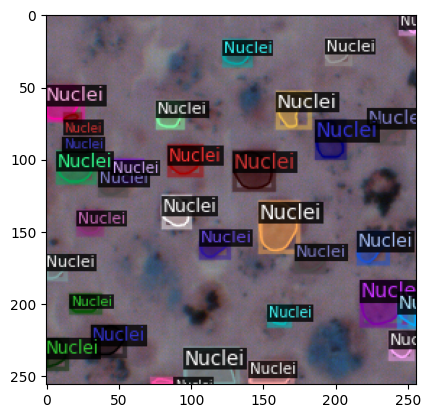

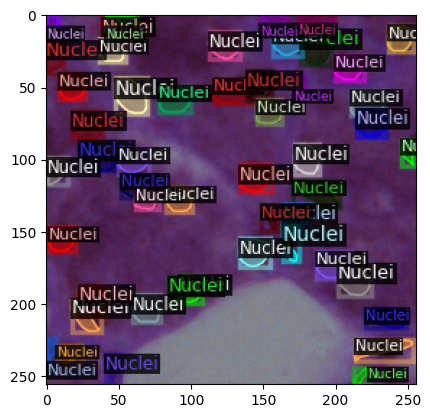

In [9]:
for sample in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(sample["file_name"])
    vis = Visualizer(img[:, :, ::-1],metadata =train_metadata, scale=0.5).draw_dataset_dict(sample)
    plt.imshow(vis.get_image()[:, :, ::-1]) #reverse the BGR TO RGB
    plt.show()

#Train

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = '/content/drive/MyDrive/Deep_Learning/Neuclei_detection/Models'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("My_dataset_train",)
cfg.DATASETS.VAL = ("My_dataset_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations for demo purposes
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available



[03/28 08:21:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 130MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [11]:
trainer.train()

[03/28 08:21:42 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/28 08:21:58 d2.utils.events]:  eta: 0:08:43  iter: 19  total_loss: 5.715  loss_cls: 0.7165  loss_box_reg: 0.5231  loss_mask: 0.6922  loss_rpn_cls: 3.343  loss_rpn_loc: 0.2776    time: 0.6102  last_time: 0.9574  data_time: 0.2413  last_data_time: 0.3946   lr: 4.9953e-06  max_mem: 2013M
[03/28 08:22:13 d2.utils.events]:  eta: 0:07:40  iter: 39  total_loss: 3.77  loss_cls: 0.6877  loss_box_reg: 0.5231  loss_mask: 0.6878  loss_rpn_cls: 1.528  loss_rpn_loc: 0.2412    time: 0.5589  last_time: 0.4690  data_time: 0.1433  last_data_time: 0.0847   lr: 9.9902e-06  max_mem: 2153M
[03/28 08:22:24 d2.utils.events]:  eta: 0:07:46  iter: 59  total_loss: 2.818  loss_cls: 0.633  loss_box_reg: 0.6617  loss_mask: 0.6778  loss_rpn_cls: 0.6024  loss_rpn_loc: 0.1989    time: 0.5635  last_time: 0.5899  data_time: 0.2077  last_data_time: 0.2780   lr: 1.4985e-05  max_mem: 2153M
[03/28 08:22:35 d2.utils.events]:  eta: 0:07:29  iter: 79  total_loss: 2.482  loss_cls: 0.5903  loss_box_reg: 0.6688  loss_mask: 0.

In [12]:
import yaml
import os
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/Deep_Learning/Neuclei_detection/Models/config-5k_iter.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

#Save the model weights with a different name so we don't accidentally overwrite our model.
os.rename(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), os.path.join(cfg.OUTPUT_DIR, "model_10k_iter.pth"))


In [22]:

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_10k_iter.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom threshold
predictor = DefaultPredictor(cfg)

[03/28 08:44:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Deep_Learning/Neuclei_detection/Models/model_10k_iter.pth ...


#TESTING

In [24]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("My_dataset_test", {}, "/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/test/coco_annotations.json", "/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/test")
test_metadata = MetadataCatalog.get("My_dataset_test")
test_dataset_dicts = DatasetCatalog.get("My_dataset_test")

AssertionError: Dataset 'My_dataset_test' is already registered!

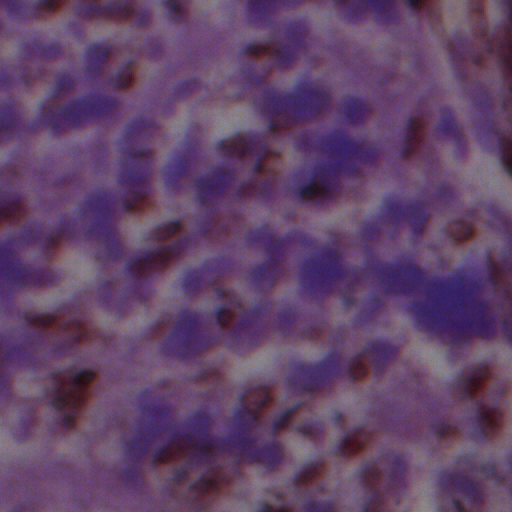

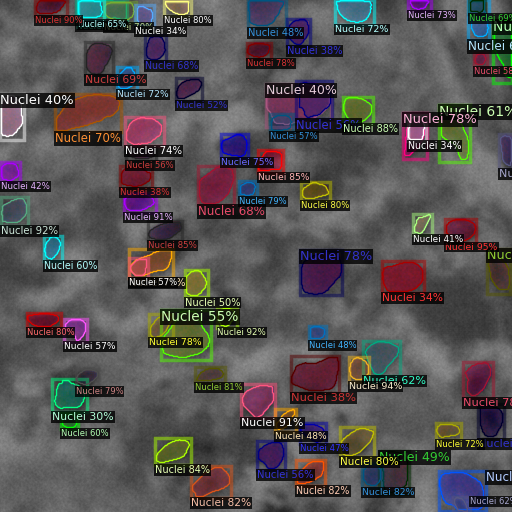

In [25]:
from detectron2.utils.visualizer import ColorMode

for sample in random.sample(test_dataset_dicts, 1):    #select number of images for display
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata = test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(img[:, :, ::-1])
    cv2_imshow(out.get_image()[:, :, ::-1])

In [26]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("My_dataset_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "My_dataset_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))

[03/28 08:45:14 d2.data.datasets.coco]: Loaded 67 images in COCO format from /content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/test/coco_annotations.json
[03/28 08:45:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/28 08:45:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/28 08:45:14 d2.data.common]: Serializing 67 elements to byte tensors and concatenating them all ...
[03/28 08:45:14 d2.data.common]: Serialized dataset takes 1.01 MiB
[03/28 08:45:14 d2.evaluation.evaluator]: Start inference on 67 batches
[03/28 08:45:15 d2.evaluation.evaluator]: Inference done 11/67. Dataloading: 0.0015 s/iter. Inference: 0.0904 s/iter. Eval: 0.0302 s/iter. Total: 0.1220 s/iter. ETA=0:00:06
[03/28 08:45:20 d2.evaluation.evaluator]: Inference done 54/67. Dataloading: 0.0019 s/iter. Inference: 0.0905 s/iter

#LOADING A NEW IMAGE A SEGMENTING IT

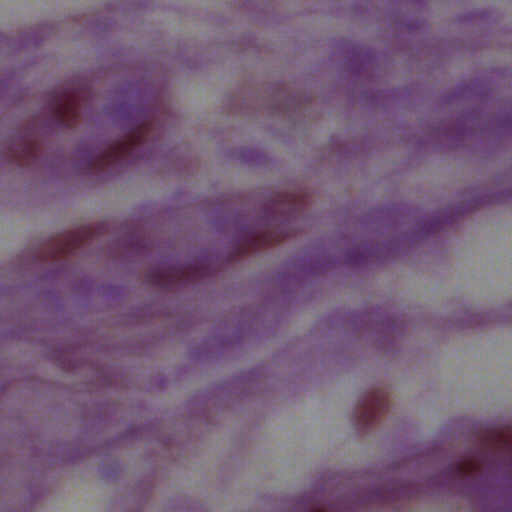

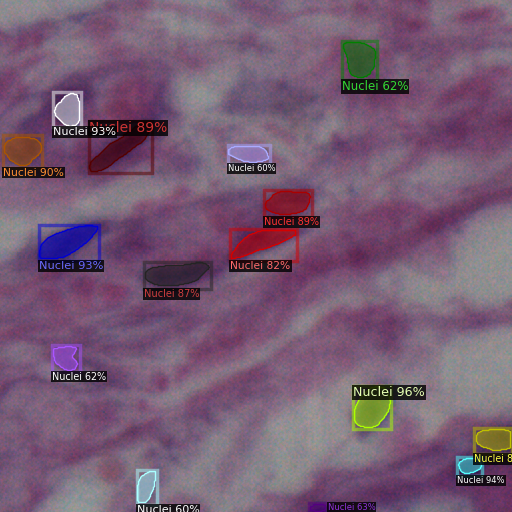

In [19]:
new_img = cv2.imread("/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/test/human_cardia_4.png")
outputs  = predictor(new_img)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_img[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(new_img[:, :, ::-1])
cv2_imshow(out.get_image()[:, :, ::-1])

In [27]:
# Commenting the following code as we often do not need to save segmented images with bounding boxes.
# We need real numbers with object measurements or labeled images as output.


# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/Deep_Learning/Neuclei_detection/COCO_output/test_output"

# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    # Check if the file has a valid image extension
    if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


Segmentation of all images completed.
